In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

**Start at:** Wednesday 31 May 2023, 09:06:53  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>


# Prediction by an artificial neural network of the solubility of CO<sub>2</sub> in ionic liquids

<div class="intro">
    
<b>Reference</b>: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [<i>Chem. Eng. Sci.</i> <b>223</b>: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 
<br>
<p style="text-align: center"><img width="650px" src="./DS4B-CO2-images/AbstractANNCO2-SongEtal.png" style="margin-left:auto; margin-right:auto" id="img_AbstractSong"></p>
<br>
The main results are graphically reported below.
<br>
<p style="text-align: center"><img width="900px" src="./DS4B-CO2-images/ANNCO2-SongEtal-Results.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
<br>
<span style="font-weight:bold">The goal of this tutorial is to reproduce the ANN part of this article. </span>

</div>


In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
    
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os,sys
from IPython.display import display

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   OFF = '\033[0m'

2023-05-31 09:06:54.620051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 09:06:54.710027: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<a id="data-read"></a>
## **1.** Basic data analysis and visualization
The [pandas library](https://pandas.pydata.org/docs/index.html) provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language. It is recommended to first have a look at the [10mn short introduction to pandas](https://pandas.pydata.org/docs/user_guide/10min.html).
### **1.a.** Read the database

In [3]:
dataCO2f='DS4B-CO2-data'+'/'+'dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### **1.b.** Data distribution?

       x_CO2
[CH3]       
0        855
1       8350
2        108
3         92
4        639
7         72

Duration :  00:00:01 187ms


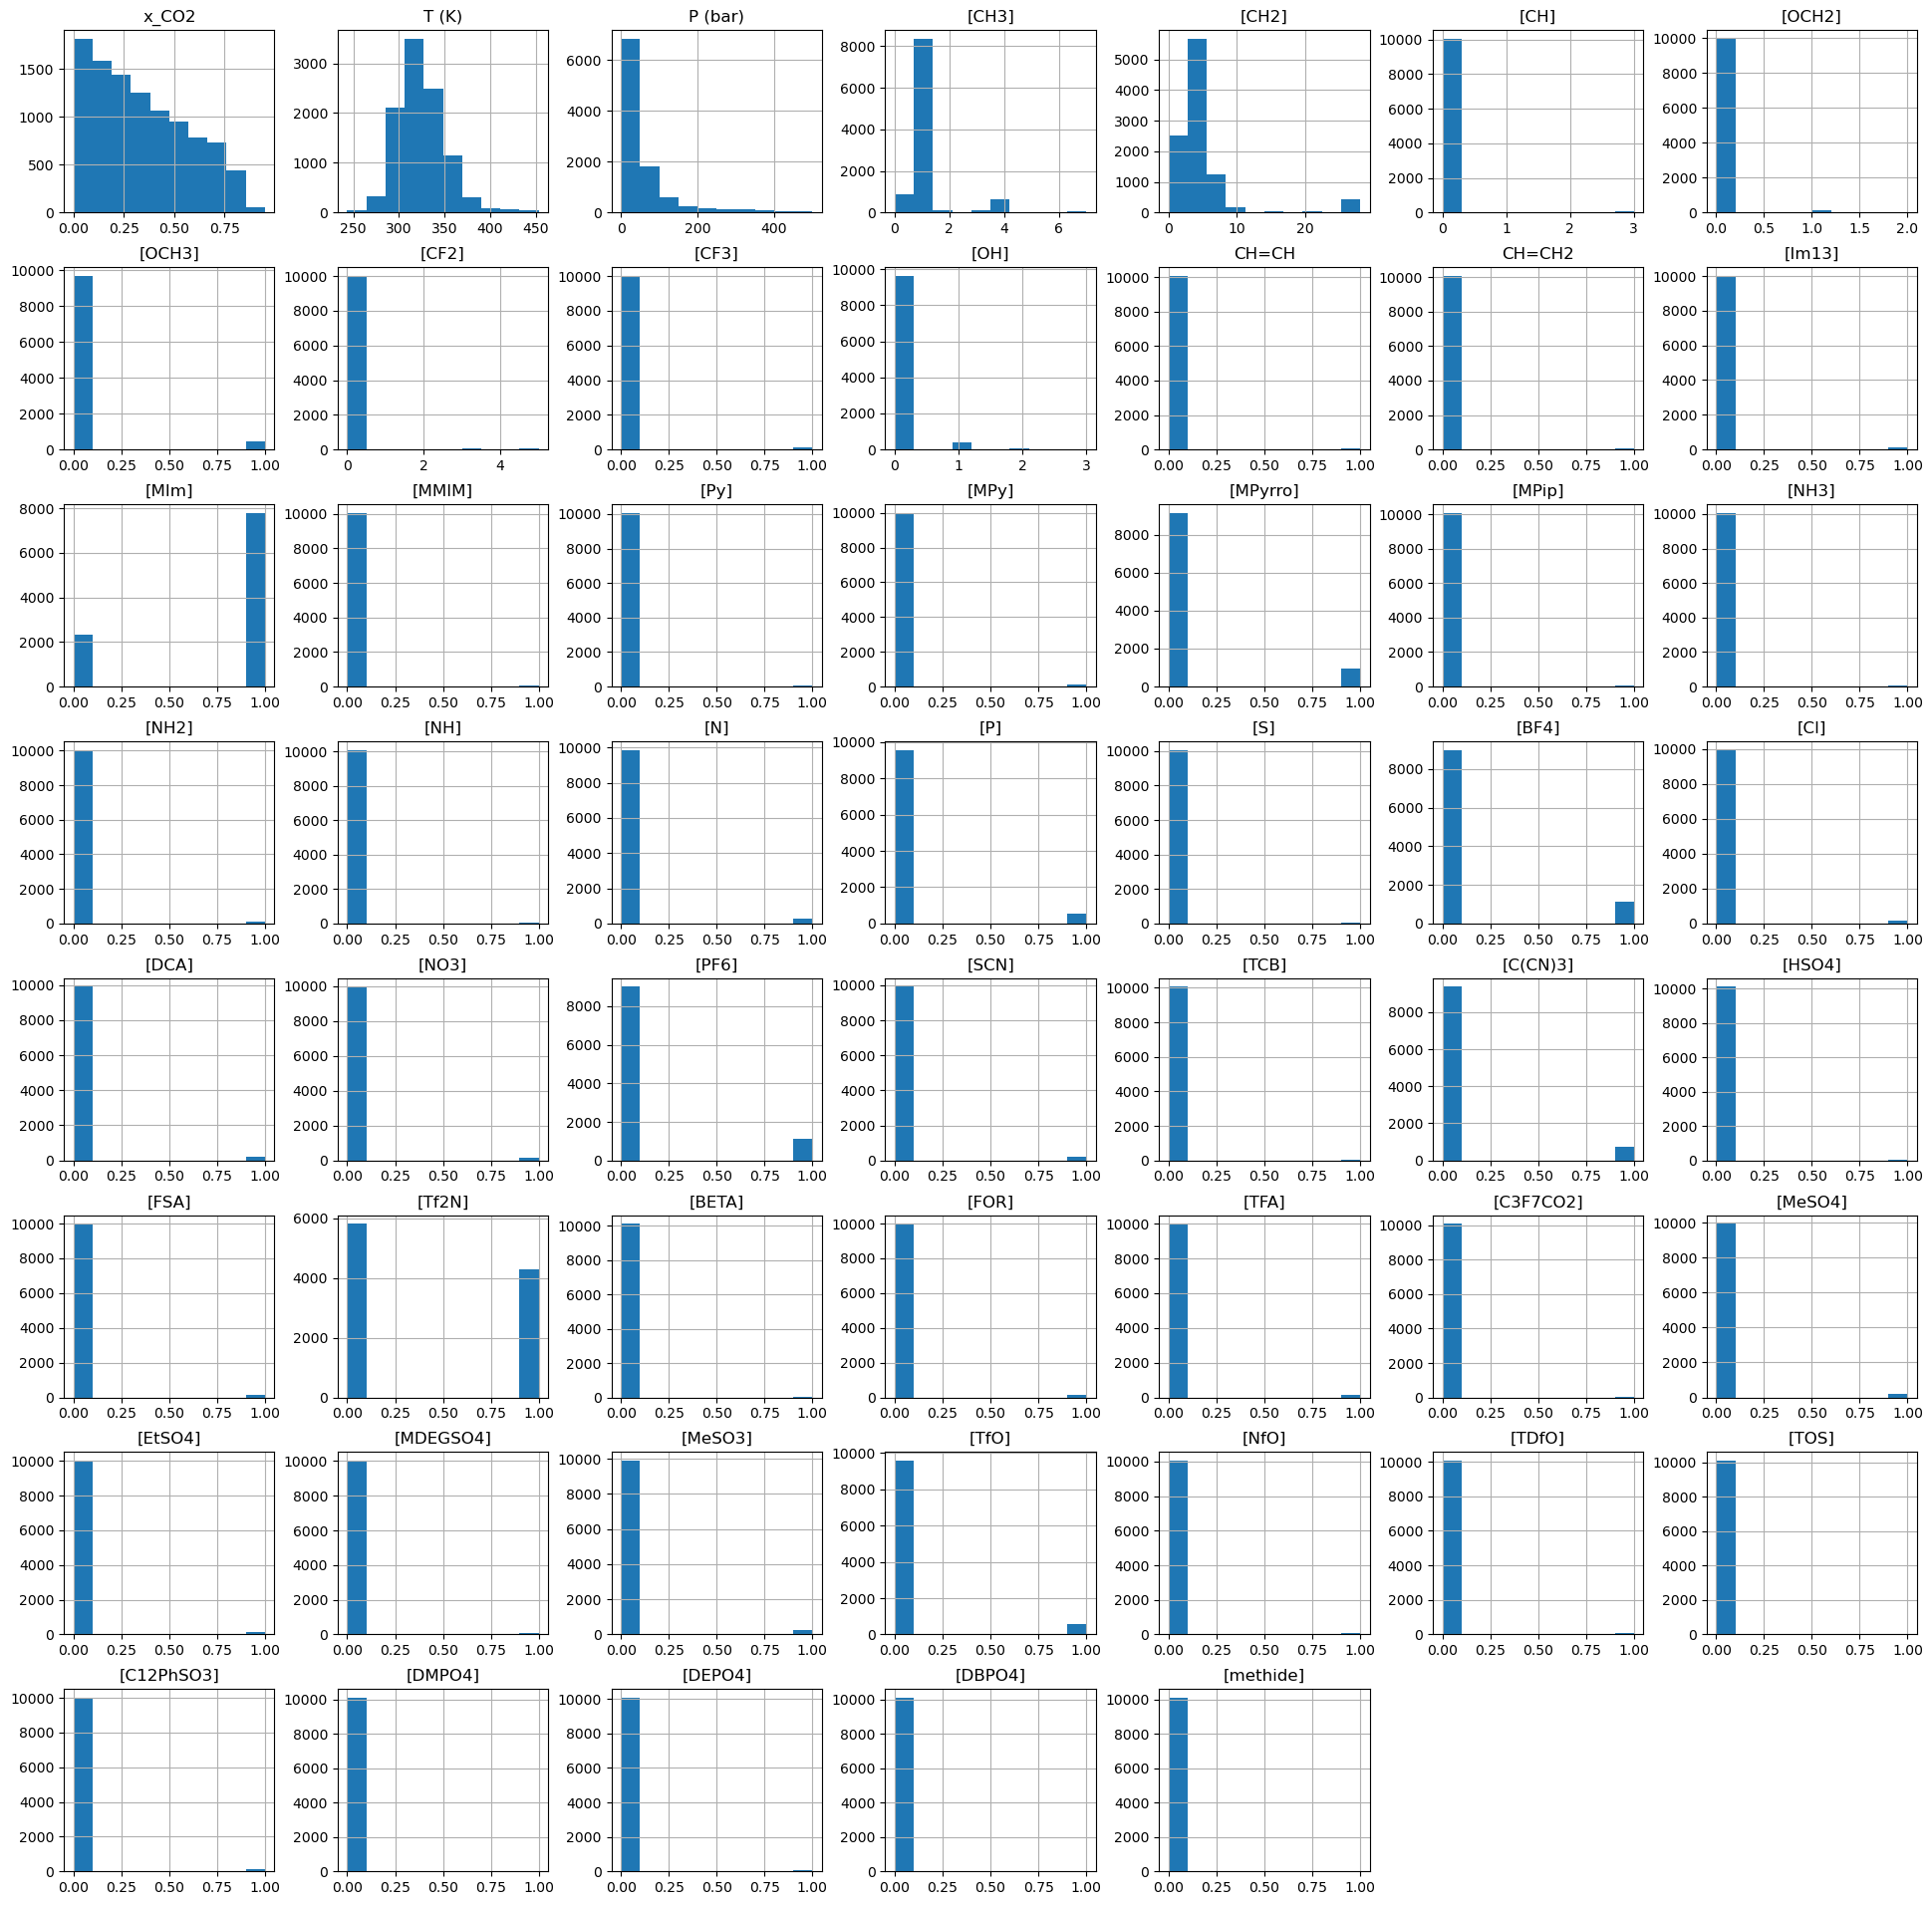

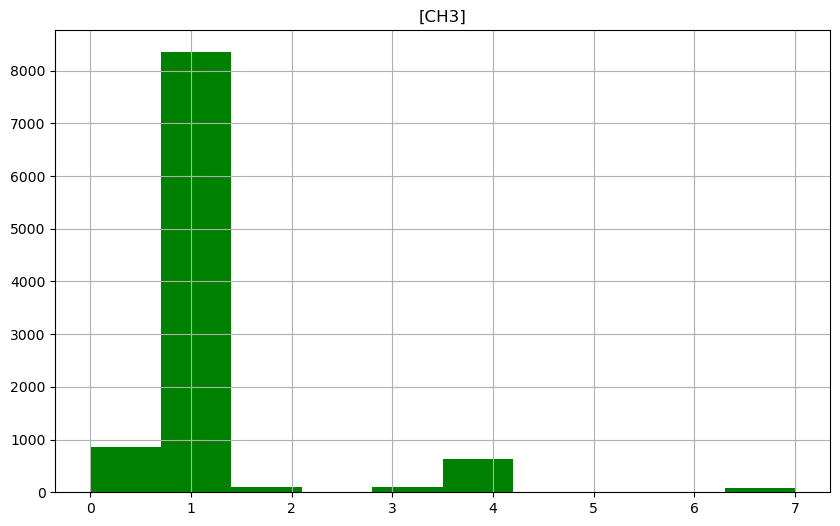

In [4]:
vID.chrono_start()
dataCO2.hist(figsize=(24,24))
print(dataCO2[["x_CO2", "[CH3]"]].groupby("[CH3]").count())
dataCO2.hist("[CH3]",figsize=(10,6),facecolor='g')
vID.chrono_show()

## 2. Prediction of the solubility of CO<sub>2</sub> by an ANN <br>a textbook case of work that does not quite meet the standards of the field 

### 2.1. ML scheme of the reference article

<p style="text-align: center"><img width="800px" src="./DS4B-CO2-images/ANN-CO2Song_etal.png" style="margin-left:auto; margin-right:auto" id="img_Song"></p>

**Methodological details:**
- The MATLAB tansig and purelin transfer functions are employed in the hidden and output layers, respectively
- The experimental data are divided into a training set (8093 points, 80% of the data) to build the model and a test set of the remaining 2023 data points to evaluate the predictive capability of the obtained model
- <span style="color:red"><b>!!!</b> Instead of performing random selection, we employ a hybrid artificial-random strategy to decompose the dataset. Specifically, the data points consisting of the least frequently used groups are equally divided into five folders <b>!!!</b></span> <span style="color:blue"><i>This is not a valid strategy. The recommended K-fold cross validation developed in the 3rd script cannot be applied here!</i></span>

### 2.2. Script 1: assesment of the reproducibility of the simulation of Song *et al.*

Errors calculated between the actual and predicted x_CO2 values (noted $Y$ and $\hat{Y}$ in equations below)  
MAE =  Mean Absolute Error 
$$\mathrm{MAE}=\frac{1}{n}\sum_{i}\left|\hat{Y}(x_{i})-Y(x_{i})\right|$$

MSE = Mean Squared Error  
$$\mathrm{MSE}=\frac{1}{n}\sum_{i}\left(\hat{Y}(x_{i})-Y(x_{i})\right)^{2}$$

In [16]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_train = dataCO2.sample(frac=0.8, axis=0)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

display(x_train,y_train)
display(x_test,y_test)

#######################################################################################
# ANN: 1 input layer (53 neurons) / 1 hidden layer (7 neurons with the reLu activation function) / 1 output layer (1 neuron with no activation function) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
2656,334.35,298.0000,1,7,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4339,313.15,20.5000,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,363.15,27.2000,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1263,347.95,10.0027,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9509,338.25,16.9300,1,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,298.20,56.5600,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3038,333.20,14.0800,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9089,343.15,110.0000,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4547,303.15,56.2000,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2656    0.74140
4339    0.35100
48      0.14100
1263    0.07100
9509    0.18050
         ...   
640     0.68450
3038    0.06692
9089    0.46280
4547    0.70100
4513    0.22100
Name: x_CO2, Length: 8093, dtype: float64

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,363.15,246.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,363.15,171.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,357.15,154.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,363.15,90.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,303.15,81.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10087,343.15,21.82,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10091,343.15,198.18,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10096,323.15,122.24,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10107,298.15,64.89,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0        0.610
6        0.500
9        0.500
21       0.350
23       0.610
         ...  
10087    0.247
10091    0.755
10096    0.774
10107    0.762
10108    0.436
Name: x_CO2, Length: 2023, dtype: float64

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hLayer (Dense)              (None, 7)                 378       
                                                                 
 oLayer (Dense)              (None, 1)                 8         
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [17]:
#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 20,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
# numpy.ravel() returns a contiguous flattened array
diffyt = ytrain_hat.ravel() - y_train.ravel()
diffyp = ytest_hat.ravel() - y_test.ravel()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1]
     )

#######################################################################################
# save model for later use

#!mkdir -p saved_models
#ANNmodel.save('saved_models/ANNmodel-basic')

Epoch 1/200
405/405 [==============================] - 1s 1ms/step - loss: 0.1374 - mae: 0.2116 - mse: 0.1374 - val_loss: 0.0233 - val_mae: 0.1106 - val_mse: 0.0233
Epoch 2/200
405/405 [==============================] - 1s 2ms/step - loss: 0.0156 - mae: 0.0960 - mse: 0.0156 - val_loss: 0.0122 - val_mae: 0.0846 - val_mse: 0.0122
Epoch 3/200
405/405 [==============================] - 1s 1ms/step - loss: 0.0122 - mae: 0.0854 - mse: 0.0122 - val_loss: 0.0108 - val_mae: 0.0794 - val_mse: 0.0108
Epoch 4/200
405/405 [==============================] - 1s 1ms/step - loss: 0.0110 - mae: 0.0808 - mse: 0.0110 - val_loss: 0.0116 - val_mae: 0.0847 - val_mse: 0.0116
Epoch 5/200
405/405 [==============================] - 0s 1ms/step - loss: 0.0104 - mae: 0.0786 - mse: 0.0104 - val_loss: 0.0094 - val_mae: 0.0738 - val_mse: 0.0094
Epoch 6/200
405/405 [==============================] - 1s 2ms/step - loss: 0.0099 - mae: 0.0763 - mse: 0.0099 - val_loss: 0.0091 - val_mae: 0.0725 - val_mse: 0.0091
Epoch 7/20

<div class="rq"><span style="color:red; font-weight:bold">

The MAE and R2 parameters seem rather good (<i>ca.</i> 0.07 and 0.92), but this prediction is actually very bad, as you will see by jumping to the <a href="#model-evaluation">Model Evaluation</a> section!</span>
<br>
Unless you were lucky (an element of chance is involved in the learning process), the predicted <i>vs.</i> actual CO<sub>2</sub> solubility probably looks like this: 
<br>
<p style="text-align: center"><img width="550px" src="./DS4B-CO2-images/predictionCO2_woStd-saved.png" style="margin-left:auto; margin-right:auto" id="img_predCO2woStd"></p>
<b>It differs a lot from the results of the reference article, reported in the introduction of this notebook.</b>
<br><br>
<span style="color:red; font-weight:bold">Origin of this weird behaviour?</span>
<br>
Probably the absence of <b>standardization</b> of the data. This scattering is by the way reminiscent the variation of the solubility as a function of <i>T</i> or <i>p</i>, plotted below. Let's check that in the next script.
</div>

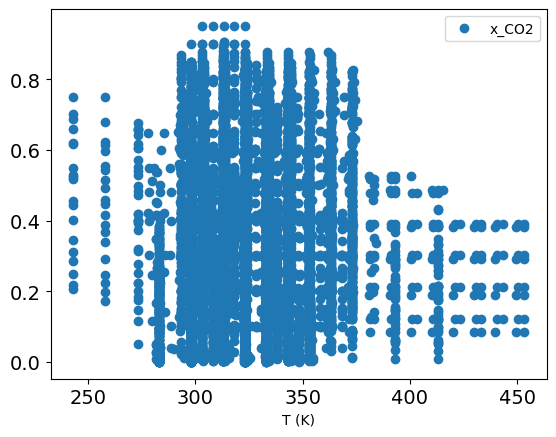

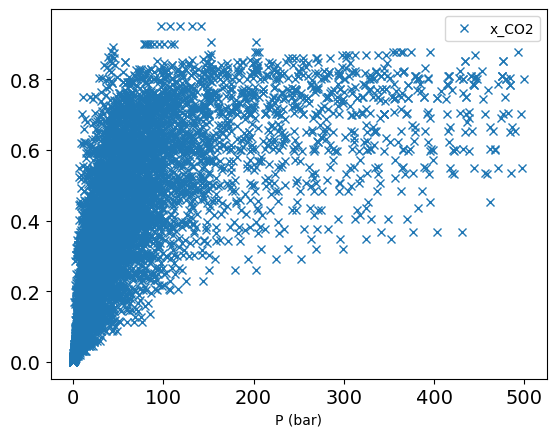

In [7]:
fig1=dataCO2.plot(x="T (K)", y=["x_CO2"],linestyle='', marker='o',fontsize=14)
fig2=dataCO2.plot(x="P (bar)", y=["x_CO2"],linestyle='', marker='x',fontsize=14)

### 2.2. Script 2: improvement of the previous script
<div class="rq">Data will now be standardized, using the <code>preprocessing</code> package provided by the <code>scikit learn</code> library</div>

In [20]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_A = dataCO2.sample(frac=0.8, axis=0, random_state=1)
data_B  = dataCO2.drop(data_A.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']
x_trainTmp = x_train.copy() # for plotting purpose
x_testTmp = x_test.copy()

display(x_train.describe().style.format("{0:.2f}").set_caption("Training set before normalization :"))

# using scikit-learn
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
xtrain_scaled = scaler.transform(x_train.values) #returns a numpy array
xtest_scaled = scaler.transform(x_test.values) #returns a numpy array
x_train = pd.DataFrame(xtrain_scaled, index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(xtest_scaled, index=x_test.index, columns=x_test.columns)

display(x_train.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))
display(x_test.describe().style.format("{0:.2f}").set_caption("Test set after normalization (with scikit-learn):"))

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,325.31,55.81,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.01,0.01,0.10,0.00,0.00,0.01,0.00,0.03,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.06,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,25.27,79.02,0.97,5.49,0.26,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.10,0.30,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.14,0.13,0.32,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.10,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.04,0.08,0.04,0.05
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,27.64,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,342.88,65.90,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,497.60,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.25,-0.71,-1.22,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,-1.81,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
25%,-0.68,-0.58,-0.19,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
50%,-0.09,-0.36,-0.19,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
75%,0.70,0.13,-0.19,0.05,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,1.16,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
max,5.06,5.59,5.99,4.24,11.47,12.32,4.76,12.78,10.01,10.56,16.39,17.28,9.43,0.55,12.81,14.01,9.48,3.04,16.97,15.17,11.03,16.39,6.22,4.18,16.13,2.87,7.95,6.83,7.83,2.81,7.09,12.68,3.57,27.11,8.60,1.16,29.97,8.64,8.94,19.61,7.54,9.43,9.54,6.54,4.08,11.47,13.23,15.87,9.65,28.43,13.08,24.02,21.18


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00
mean,-0.01,-0.10,-0.03,0.00,-0.02,0.02,-0.00,0.01,0.01,0.00,0.04,0.05,-0.02,0.05,0.02,-0.02,0.01,-0.05,0.01,0.03,-0.02,-0.02,-0.01,-0.01,0.00,0.03,-0.01,0.03,-0.01,-0.03,0.04,-0.00,0.04,-0.01,0.00,-0.02,-0.00,-0.00,0.00,0.02,0.01,0.01,-0.02,-0.00,-0.04,0.01,0.01,-0.03,0.02,-0.01,-0.01,0.01,-0.02
std,1.00,0.84,0.95,1.00,0.85,1.04,0.99,1.06,1.02,1.04,1.26,1.33,0.90,0.97,1.14,0.83,1.06,0.92,1.07,1.22,0.85,0.82,0.96,0.98,1.02,1.04,0.98,1.08,0.96,0.97,1.12,0.98,1.06,0.85,1.00,1.00,0.94,0.99,1.02,1.15,1.04,1.03,0.91,0.99,0.92,1.06,1.06,0.71,1.10,0.89,0.92,1.07,0.82
min,-3.25,-0.71,-1.22,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,-1.81,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
25%,-0.68,-0.59,-0.19,-0.50,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
50%,-0.09,-0.41,-0.19,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
75%,0.51,0.06,-0.19,0.05,-0.09,-0.12,-0.21,-0.10,-0.10,-0.21,-0.06,-0.06,-0.11,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.36,-0.14,-0.08,-0.28,-0.04,-0.12,1.16,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
max,4.95,5.62,5.99,4.24,11.47,12.32,4.76,12.78,10.01,10.56,16.39,17.28,9.43,0.55,12.81,14.01,9.48,3.04,16.97,15.17,11.03,16.39,6.22,4.18,16.13,2.87,7.95,6.83,7.83,2.81,7.09,12.68,3.57,27.11,8.60,1.16,29.97,8.64,8.94,19.61,7.54,9.43,9.54,6.54,4.08,11.47,13.23,15.87,9.65,28.43,13.08,24.02,21.18


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hLayer (Dense)              (None, 7)                 378       
                                                                 
 oLayer (Dense)              (None, 1)                 8         
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


/tmp/ipykernel_21658/829501850.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax00=plt.subplot(gs[0,0], title="Before standardization")


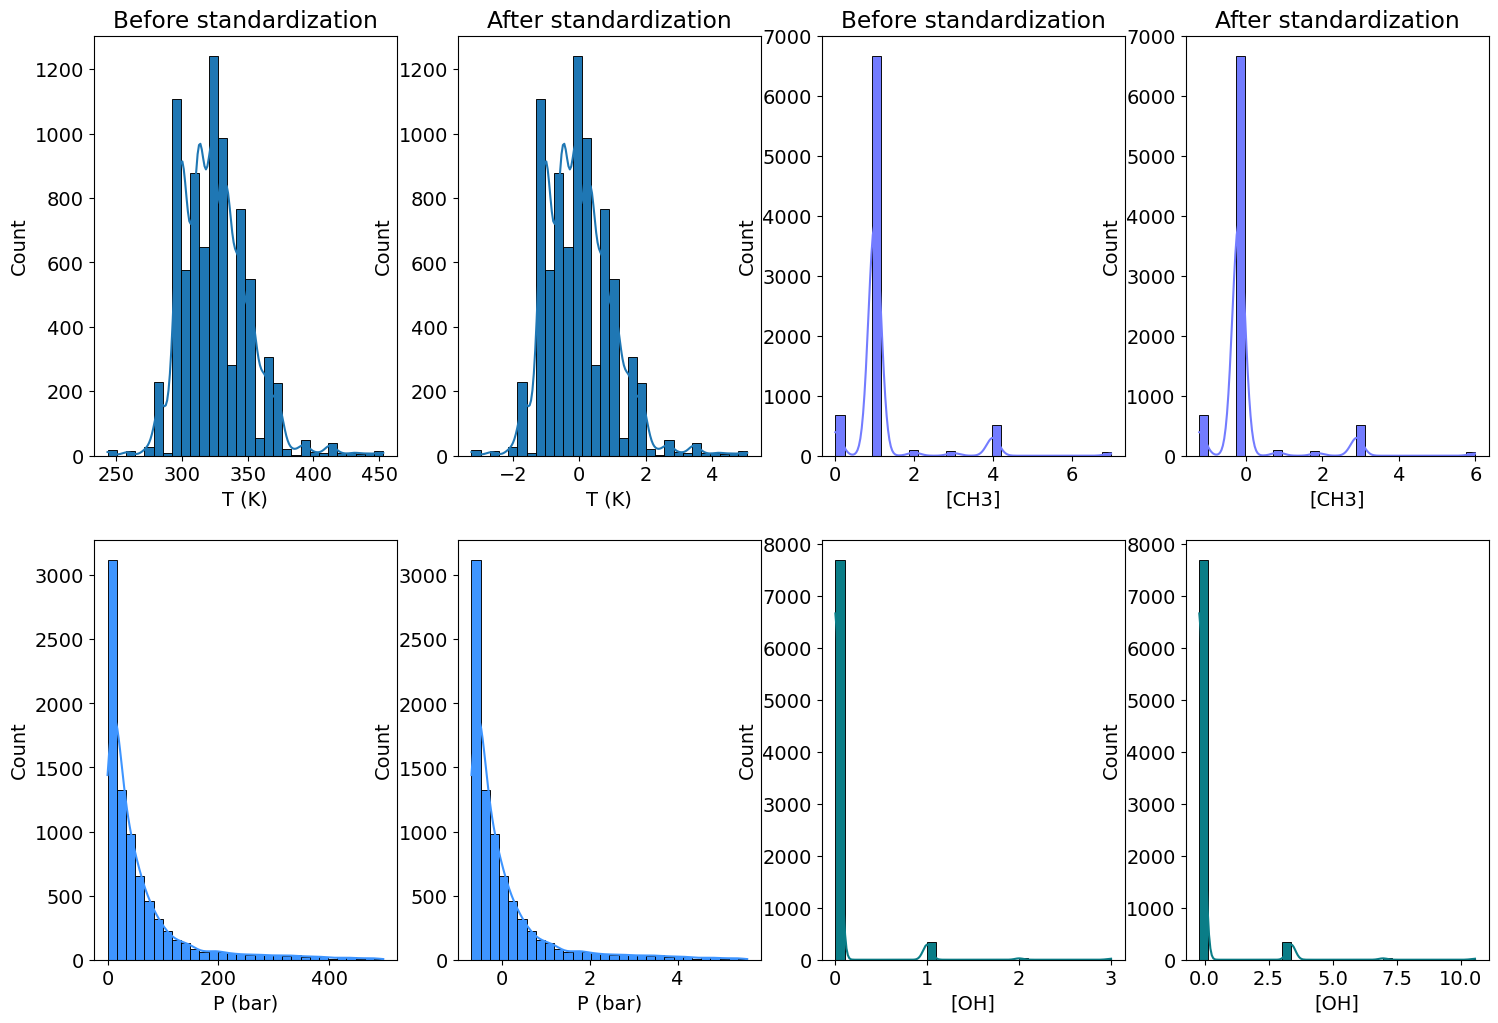

In [21]:
#######################################################################################
# graphic representation of the previous tables
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

nbins=30
fig = plt.figure(figsize=(18, 12))
plt.rcParams["font.size"] = (14) #font size
plt.tick_params(axis='x',labelsize = 16)
plt.tick_params(axis='y',labelsize = 12)
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

ax00=plt.subplot(gs[0,0], title="Before standardization")
fig00=sns.histplot(data=x_trainTmp,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax10=plt.subplot(gs[1,0])
fig10=sns.histplot(data=x_trainTmp,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)
ax01=plt.subplot(gs[0,1], title="After standardization")
fig01=sns.histplot(data=x_train,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax11=plt.subplot(gs[1,1])
fig11=sns.histplot(data=x_train,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)

ax02=plt.subplot(gs[0,2], title="Before standardization")
fig02=sns.histplot(data=x_trainTmp,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax12=plt.subplot(gs[1,2])
fig12=sns.histplot(data=x_trainTmp,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)
ax03=plt.subplot(gs[0,3], title="After standardization")
fig03=sns.histplot(data=x_train,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax13=plt.subplot(gs[1,3])
fig13=sns.histplot(data=x_train,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)

plt.savefig('./DS4B-CO2-images/Standardization_CO2data.png',dpi=300,bbox_inches='tight')

del xtrain_scaled, xtest_scaled
del x_trainTmp, x_testTmp

In [22]:
#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 25,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
# numpy.ravel() returns a contiguous flattened array
diffyt = ytrain_hat.ravel() - y_train.ravel()
diffyp = ytest_hat.ravel() - y_test.ravel()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1]
     )

#######################################################################################
# save model for later use

#!mkdir -p saved_models
#ANNmodel.save('saved_models/ANNmodel-basic')

Epoch 1/200
324/324 [==============================] - 1s 2ms/step - loss: 0.1889 - mae: 0.2549 - mse: 0.1889 - val_loss: 0.0406 - val_mae: 0.1359 - val_mse: 0.0406
Epoch 2/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0319 - mae: 0.1209 - mse: 0.0319 - val_loss: 0.0245 - val_mae: 0.1104 - val_mse: 0.0245
Epoch 3/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0256 - mae: 0.1086 - mse: 0.0256 - val_loss: 0.0207 - val_mae: 0.1020 - val_mse: 0.0207
Epoch 4/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0204 - mae: 0.0981 - mse: 0.0204 - val_loss: 0.0163 - val_mae: 0.0927 - val_mse: 0.0163
Epoch 5/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0161 - mae: 0.0881 - mse: 0.0161 - val_loss: 0.0125 - val_mae: 0.0836 - val_mse: 0.0125
Epoch 6/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0111 - mae: 0.0781 - mse: 0.0111 - val_loss: 0.0104 - val_mae: 0.0764 - val_mse: 0.0104
Epoch 7/20

<div class="rq">
    Once completed, jump to the <a href="#model-evaluation">Model Evaluation</a> section
</div>

### 2.3. Script 3: assessment of the stability of the ML algorithm by *K*-fold cross validation
<div class="rq">Script 2 is now adapted to assess how the results of the ML generalizes</div>
<br>
<div class="intro">
The main idea behind cross-validation is that each sample in a dataset has the opportunity of being tested. K-fold cross-validation is a special case of cross-validation where we iterate over a dataset set <i>k</i> times. The dataset is split into <i>k</i> parts at each iteration: one part is used for validation, and the remaining <i>k</i>−1  parts are merged into a training subset for model evaluation. The figure below illustrates the process of 5-fold cross-validation
<p style="text-align: center"><img width="520px" src="DS4B-svg/KFoldCV.svg" style="margin-left:auto; margin-right:auto" id="img_5FoldCV"></p>
</div>

In [16]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
xdata = dataCO2.drop(['IL','cation','anion','x_CO2'],axis=1)
ydata = dataCO2['x_CO2']

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'

Fold 0
Epoch 1/200
324/324 [==============================] - 1s 1ms/step - loss: 0.1641 - mae: 0.2348 - mse: 0.1641 - val_loss: 0.0333 - val_mae: 0.1226 - val_mse: 0.0333
Epoch 2/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0251 - mae: 0.1076 - mse: 0.0251 - val_loss: 0.0219 - val_mae: 0.1009 - val_mse: 0.0219
Epoch 3/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0177 - mae: 0.0915 - mse: 0.0177 - val_loss: 0.0165 - val_mae: 0.0872 - val_mse: 0.0165
Epoch 4/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0134 - mae: 0.0808 - mse: 0.0134 - val_loss: 0.0116 - val_mae: 0.0777 - val_mse: 0.0116
Epoch 5/200
324/324 [==============================] - 0s 2ms/step - loss: 0.0103 - mae: 0.0731 - mse: 0.0103 - val_loss: 0.0099 - val_mae: 0.0711 - val_mse: 0.0099
Epoch 6/200
324/324 [==============================] - 0s 1ms/step - loss: 0.0087 - mae: 0.0676 - mse: 0.0087 - val_loss: 0.0089 - val_mae: 0.0677 - val_mse: 0.0089
Epo

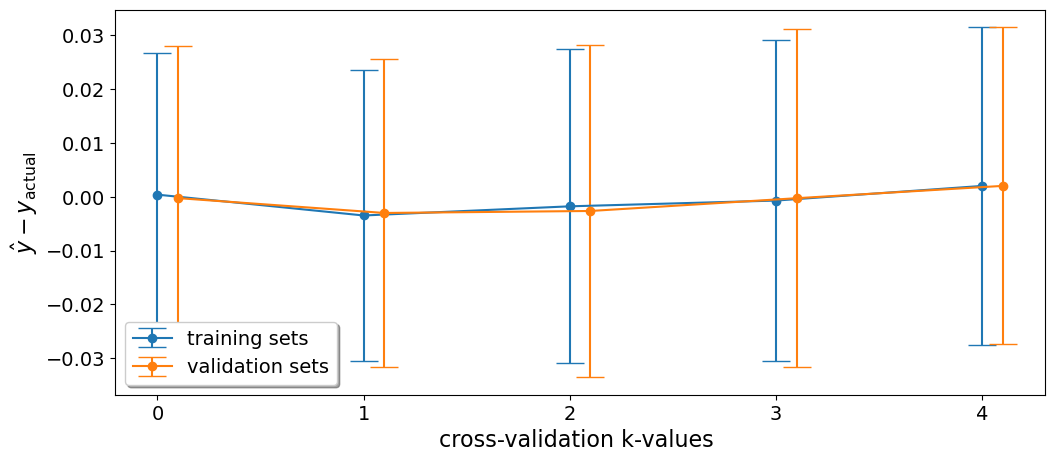

In [17]:
#######################################################################################
# optimization of the ANN
# library used: keras and scikit learn for the KFold cross-validator
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
from sklearn.model_selection import KFold
from sklearn import preprocessing

VERBOSE = 1
EPOCHS = 200
BATCH_SIZE = 25
N_SPLIT = 5

vID.chrono_start()

# variables created to save at each iteration of the KFold process: the mean error, the standard deviation, MAE, R2
meantT=list()
stdtT=list()
MAEtT=list()
R2tT=list()
meanvT=list()
stdvT=list()
MAEvT=list()
R2vT=list()

kfold = KFold(n_splits=N_SPLIT,shuffle=True,random_state=42) # k-fold is here!
#print(list(kfold.split(x_train,y_train)))

j = 0 # Variable for keeping count of split we are executing
# The KFold cv provides train/test indices to split data in train/test sets
for train_idx, val_idx in list(kfold.split(xdata,ydata)):

    x_train_cv = xdata.iloc[train_idx]
    x_valid_cv = xdata.iloc[val_idx]
    y_train_cv = ydata.iloc[train_idx]
    y_valid_cv = ydata.iloc[val_idx]
#    display(x_train_cv,x_valid_cv)
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train_cv.values)
    xt_scaled = scaler.transform(x_train_cv.values) #returns a numpy array
    xv_scaled = scaler.transform(x_valid_cv.values) #returns a numpy array
    x_train_cv = pd.DataFrame(xt_scaled, index=x_train_cv.index, columns=x_train_cv.columns) #conversion of a numpy array into a pandas dataframe
    x_valid_cv = pd.DataFrame(xv_scaled, index=x_valid_cv.index, columns=x_valid_cv.columns) #conversion of a numpy array into a pandas dataframe
    del xt_scaled, xv_scaled
#    display(x_train_cv.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))
#    display(x_valid_cv.describe().style.format("{0:.2f}").set_caption("Validation set after normalization (with scikit-learn):"))
    print(f"{color.BOLD}{color.RED}Fold {j}{color.OFF}")
    j+=1
    ANNmodel=defANN( (53,), acthL )
    ANNhistory = ANNmodel.fit(x_train_cv,
                        y_train_cv,
                        epochs          = EPOCHS,
                        batch_size      = BATCH_SIZE,
                        verbose         = VERBOSE,
                        validation_data = (x_valid_cv, y_valid_cv),
                        callbacks=[es])
    ytrain_hat=ANNmodel.predict(x_train_cv)
    yvalid_hat=ANNmodel.predict(x_valid_cv)
    # numpy.ravel() returns a contiguous flattened array
    diffyt = ytrain_hat.ravel() - y_train_cv.ravel()
    diffyv = yvalid_hat.ravel() - y_valid_cv.ravel()

    print()
    print("xCO2(predicted) - xCO2(actual)")
    print(
          "Train.","mean: ", np.mean(diffyt),
          "   std: ", np.std(diffyt),
          "   MAE: ", np.average(abs(diffyt)),
          "    R2: ", np.corrcoef(y_train_cv.ravel(),ytrain_hat.ravel())[0,1]
         )
    print(
          "Test.","mean: ", np.mean(diffyv),
          "   std: ", np.std(diffyv),
          "   MAE: ", np.average(abs(diffyv)),
          "    R2: ", np.corrcoef(y_valid_cv.ravel(),yvalid_hat.ravel())[0,1]
         )
    meantT.append(np.mean(diffyt))
    meanvT.append(np.mean(diffyv))
    stdtT.append(np.std(diffyt))
    stdvT.append(np.std(diffyv))
    MAEtT.append(np.average(abs(diffyt)))
    MAEvT.append(np.average(abs(diffyv)))
    R2tT.append(np.corrcoef(y_train_cv.ravel(),ytrain_hat.ravel())[0,1])
    R2vT.append(np.corrcoef(y_valid_cv.ravel(),yvalid_hat.ravel())[0,1])
    
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy
print(f"{color.BOLD}average MAE of the training set:{color.OFF}   {np.mean(MAEtT):.2f} +/- {np.std(MAEtT):.2f}")
print(f"{color.BOLD}average MAE of the validation set:{color.OFF} {np.mean(MAEvT):.2f} +/- {np.std(MAEvT):.2f}")

figCV, axCV = plt.subplots(1, 1)
figCV.set_size_inches(12,5)
axCV.errorbar(x=np.arange(len(meantT)), y=meantT, yerr=MAEtT, label='training sets', fmt='o-', capsize=10)
axCV.errorbar(x=np.arange(len(meanvT))+0.1, y=meanvT, yerr=MAEvT, label='validation sets', fmt='o-', capsize=10)
axCV.legend(loc='lower left', shadow=True, fontsize='14')
axCV.set_xlabel('cross-validation k-values ',fontdict={'fontsize':16})
axCV.set_ylabel('$\hat{y}-y_{\mathrm{actual}}$',fontdict={'fontsize':16})
axCV.tick_params(labelsize = 14)
plt.savefig('./DS4B-CO2-images/KFold-cv.png',dpi=300,bbox_inches='tight')
plt.show()

<div class="rq">
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. It generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split. Although the CO<sub>2</sub> data set contains more than 10k samples, it is always worth proving the stability of an ML algorithm. As a result, it is a pity that a scheme such as the one just determined above (and in principle close to the one reported below) is not available in the Song <i>et al.</i> publication, at least in the supplementary information part.
<p style="text-align: center"><img width="650px" src="./DS4B-CO2-images/KFold-cvK.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
<b>This error plot shows a good performance of the ML algorithm, as well as similar error bars, regardless of the training data set.</b>
</div>

<div class="rq">

**Do you want to evaluate the last opimized model of the K-fold process?**

evaluate the next Python cell for compatibility purpose with the **Model Evaluation** section
</div>

In [42]:
y_train = y_train_cv.copy()
y_test = y_valid_cv.copy()
ytest_hat = yvalid_hat.copy()

## <a id="model-evaluation"></a>Model evaluation

### **3.1.** Loss, MAE and MSE as a function of epochs = during the ANN optimization with the back-propagation algorithm 

x_train / loss      : 0.0014
x_train / mae       : 0.0271
x_train / mse       : 0.0014

x_test / loss       : 0.0017
x_test / mae        : 0.0285
x_test / mse        : 0.0017


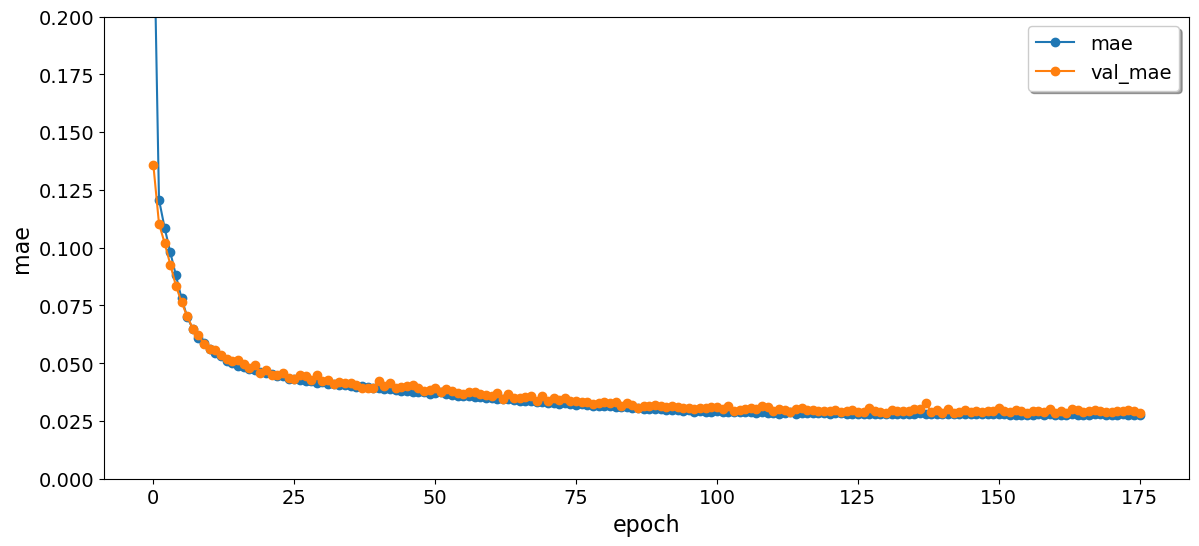

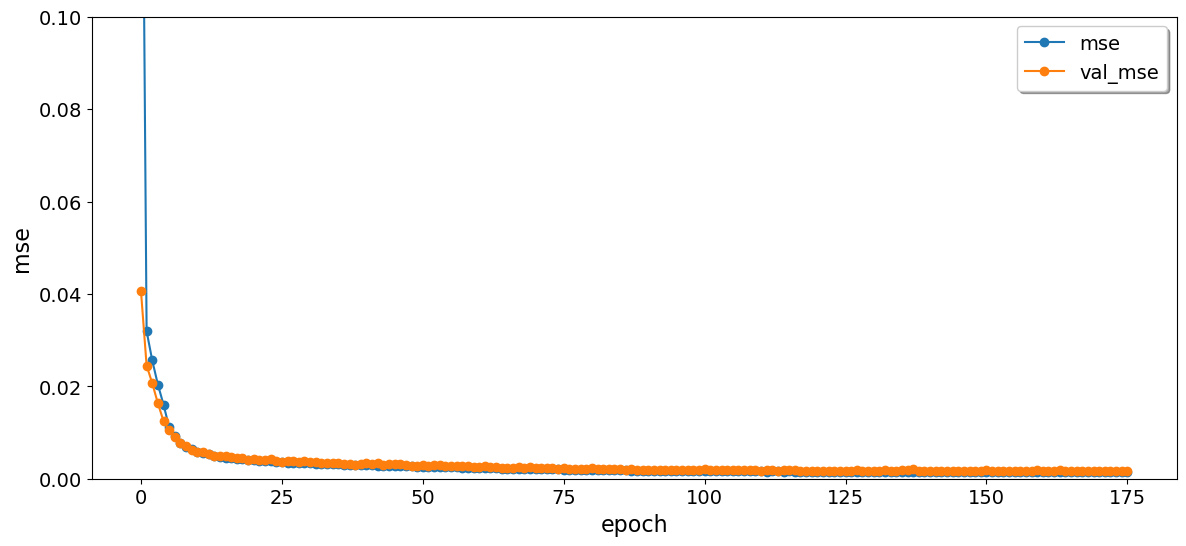

In [23]:
ANNscoreTrain= ANNmodel.evaluate(x_train, y_train, verbose=0)
print(f"{color.GREEN}x_train / loss      : {ANNscoreTrain[0]:5.4f}")
print(f"x_train / mae       : {ANNscoreTrain[1]:5.4f}")
print(f"x_train / mse       : {ANNscoreTrain[2]:5.4f}{color.OFF}")
print()
ANNscoreEval = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(f"{color.BLUE}x_test / loss       : {ANNscoreEval[0]:5.4f}")
print(f"x_test / mae        : {ANNscoreEval[1]:5.4f}")
print(f"x_test / mse        : {ANNscoreEval[2]:5.4f}{color.OFF}")

df=pd.DataFrame(data=ANNhistory.history)
plt.rcParams["figure.figsize"] = (14,6)
figMAE=df.plot(y=["mae","val_mae"],linestyle='-', marker='o',fontsize=14)
figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
figMAE.set_ylabel('mae',fontdict={'fontsize':16})
figMAE.set_ylim([0.0,0.2])
figMAE.legend(loc='upper right', shadow=True, fontsize='14')
figMSE=df.plot(y=["mse","val_mse"],linestyle='-', marker='o',fontsize=14)
figMSE.set_xlabel('epoch',fontdict={'fontsize':16})
figMSE.set_ylabel('mse',fontdict={'fontsize':16})
figMSE.set_ylim([0.0,0.1])
figMSE.legend(loc='upper right', shadow=True, fontsize='14')

### **3.2.** Comparison between experimental and predicted CO<sub>2</sub> solubility

/tmp/ipykernel_21658/2185132953.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0=plt.subplot(gs[0])


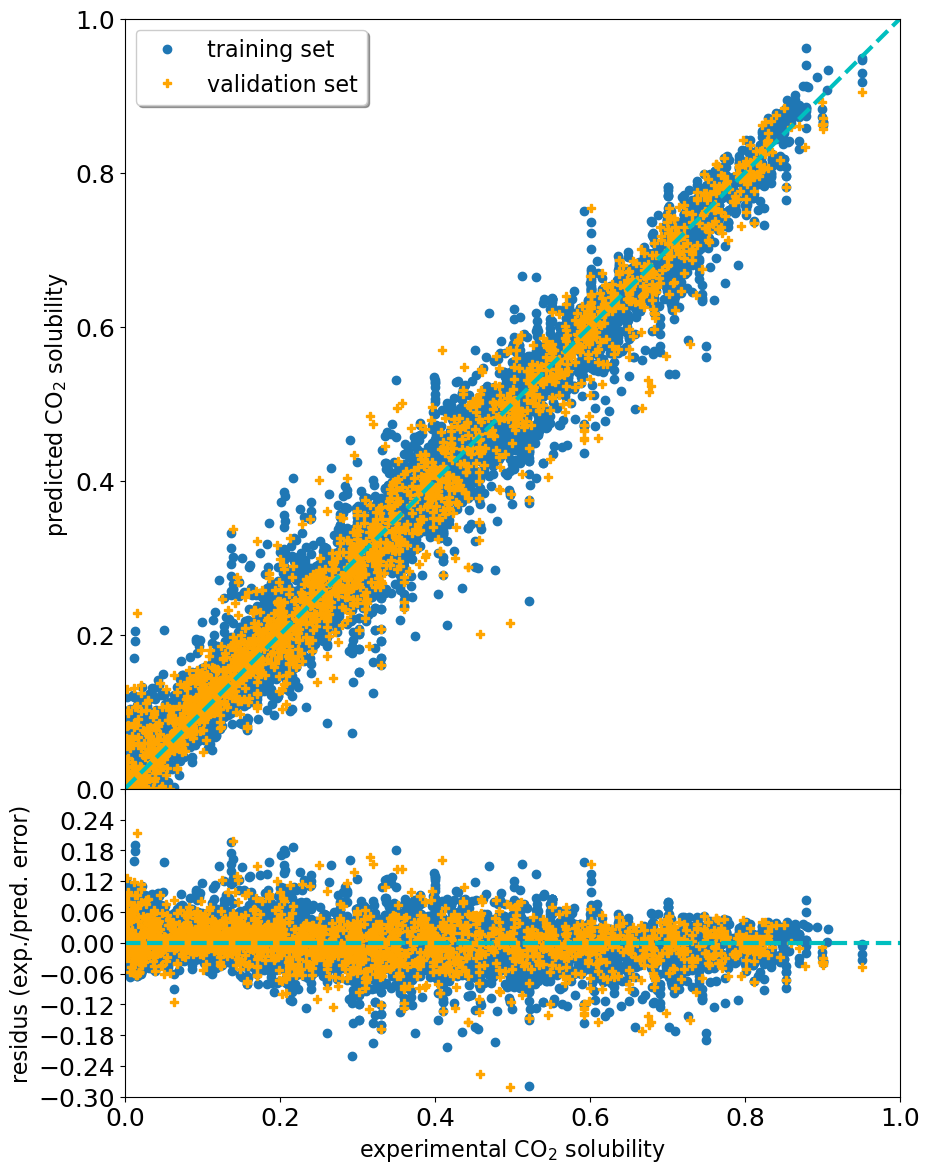

In [24]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

xD=[0,1]
yD=[0,1]
fig = plt.figure(figsize=(10, 14))
plt.rcParams["font.size"] = (18) #font size
plt.tick_params(labelsize = 14)
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 4], hspace=0)
ax0=plt.subplot(gs[0])
ax0.plot(y_train,ytrain_hat,'o',color="#1f77b4",label='training set')
ax0.plot(y_test,ytest_hat,'P',color="orange",label='validation set')
ax0.plot(xD,yD,'c',linestyle='--',lw=3)
ax0.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
ax0.set_ylabel('predicted CO$_2$ solubility',fontsize=16)
ax0.set_xlim(0,1);ax0.set_ylim(0,1) 
ax0.legend(loc='upper left', shadow=True, fontsize='16')
plt.setp(ax0.get_xticklabels(), visible=False) #cosmetics

ax1=plt.subplot(gs[1])
ax1.plot(y_train,diffyt,'o',color="#1f77b4",label='training set')
ax1.plot(y_test,diffyp,'P',color="orange",label='validation set')
ax1.axhline(y=0, xmin=0., xmax=1.0, color='c', linestyle='--', linewidth=3)
ax1.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
ax1.set_ylabel('residus (exp./pred. error)',fontsize=16)
ax1.set_xlim(0.0,1.0); ax1.set_ylim(-0.3,0.3)
ax1.axes.get_yaxis().set_major_locator(MaxNLocator(prune='upper'))  #cosmetics

plt.savefig('./DS4B-CO2-images/predictionCO2.png',dpi=300,bbox_inches='tight')

### **3.3.** Residus plotted as histograms (distribution of the error)

 Train. mean: 0.000    std: 0.037    MAE: 0.027     R2: 0.987
  Test. mean: 0.000    std: 0.041    MAE: 0.029     R2: 0.985


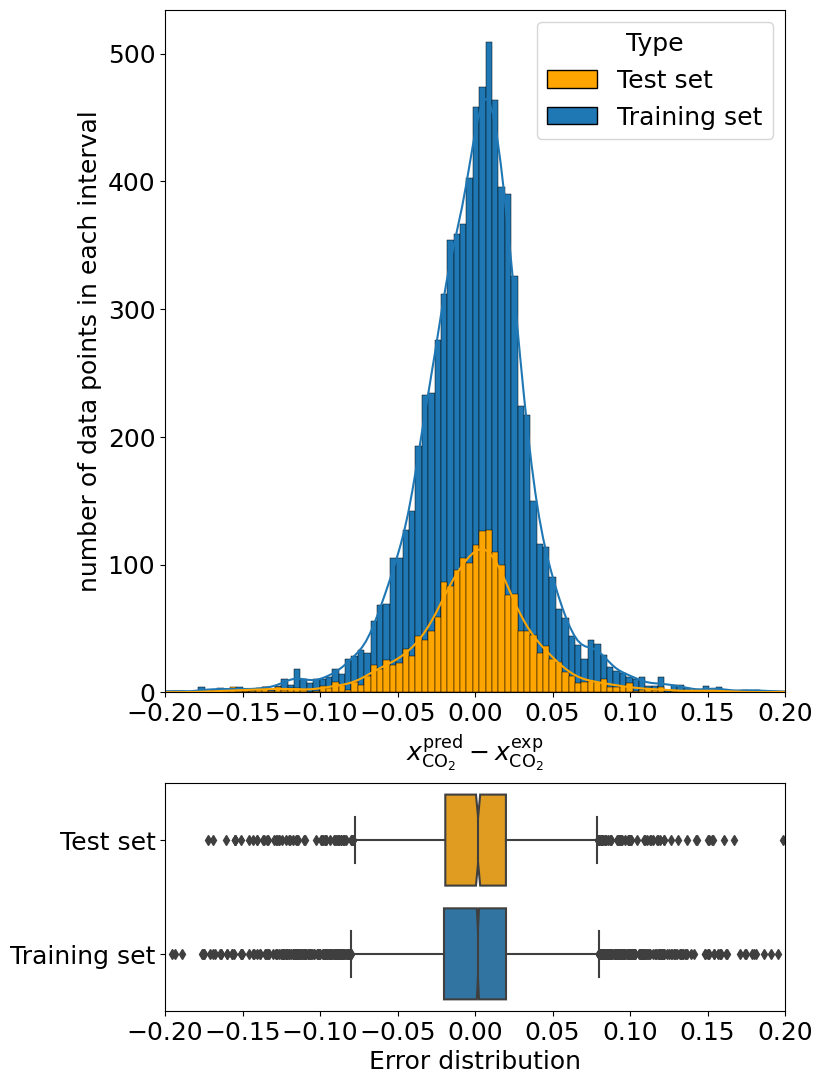

In [25]:
# numpy.ravel() returns a contiguous flattened array
print(color.BLUE,
      "Train.","mean: {:.3f}".format(np.mean(diffyt)),
      "   std: {:.3f}".format(np.std(diffyt)),
      "   MAE: {:.3f}".format(np.average(abs(diffyt))),
      "    R2: {:.3f}".format(np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1])
     )
print(color.YELLOW,
      " Test.","mean: {:.3f}".format(np.mean(diffyp)),
      "   std: {:.3f}".format(np.std(diffyp)),
      "   MAE: {:.3f}".format(np.average(abs(diffyp))),
      "    R2: {:.3f}".format(np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1])
     )

# make a dataframe
df1 = pd.DataFrame(
    {
        "Error distribution": diffyp,
        "Type": 'Test set'    },
)
#display(df1)
df2 = pd.DataFrame(
    {
        "Error distribution": diffyt,
        "Type": 'Training set'    },
)
#display(df2)
distrib=pd.concat([df1,df2],ignore_index=True)
#display(distrib)

xlim=0.2
nbins=120

import matplotlib.gridspec as gridspec
plt.rcParams["figure.figsize"] = (8,13) #graphic size
plt.rcParams["font.size"] = (18) #font size
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplot(gs[0])
fig1=sns.histplot(data=distrib,x="Error distribution", hue="Type", bins=nbins, kde=True, palette=['Orange','#1f77b4'], alpha=1.0)
plt.xlabel("$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$")
plt.ylabel("number of data points in each interval")
plt.xlim(-xlim,xlim)
plt.subplot(gs[1])
plt.xlim(-xlim,xlim)
fig2=sns.boxplot(data=distrib, x="Error distribution", y="Type", notch=True, orient = 'h',palette=['Orange','#1f77b4'])
fig2.set(ylabel=None)
plt.savefig('./DS4B-CO2-images/errorCO2.png',dpi=300,bbox_inches='tight')

## 4. Appendix: activation functions

In [22]:
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)
pw=4
ph=4


#### relu function

$$R(z)=\begin{cases}
\begin{array}{cc}
z & \,\,\,\,\,\,\,z>0\\
0 & \,\,\,\,\,\,\,z\leq0
\end{array}\end{cases}$$

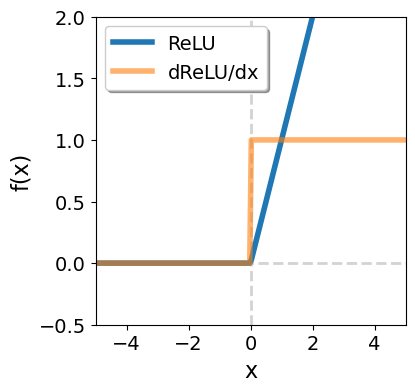

In [23]:
def relu(z):
    return np.maximum(0, z)

figR, axR = plt.subplots(1, 1)
figR.set_size_inches(pw,ph)
axR.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axR.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axR.plot(z, relu(z),linewidth=4,label="ReLU")
axR.plot(z, derivative(relu, z), linewidth=4, alpha=0.6, label="dReLU/dx")
axR.legend(loc='upper left', shadow=True, fontsize='14')
axR.set_xlabel('x',fontdict={'fontsize':16})
axR.set_ylabel('f(x)',fontdict={'fontsize':16})
axR.set_xlim(-5, 5)
axR.set_ylim(-0.5, 2)
axR.tick_params(labelsize = 14)
plt.show()


#### tanh function

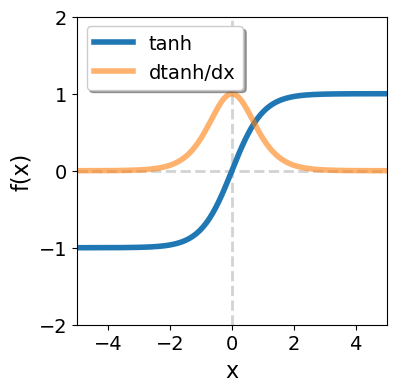

In [24]:
def tanh(z):
    return np.tanh(z)

figT, axT = plt.subplots(1, 1)
figT.set_size_inches(pw,ph)
axT.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axT.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axT.plot(z, tanh(z),linewidth=4,label="tanh")
axT.plot(z, derivative(tanh, z), linewidth=4, alpha=0.6, label="dtanh/dx")
axT.legend(loc='upper left', shadow=True, fontsize='14')
axT.set_xlabel('x',fontdict={'fontsize':16})
axT.set_ylabel('f(x)',fontdict={'fontsize':16})
axT.set_xlim(-5, 5)
axT.set_ylim(-2, 2)
axT.tick_params(labelsize = 14)
plt.show()


#### softmax function
$$\sigma_{i}(\boldsymbol{x})=\frac{e^{x_{i}}}{\sum_{j=1}^{K}e^{x_{j}}}$$

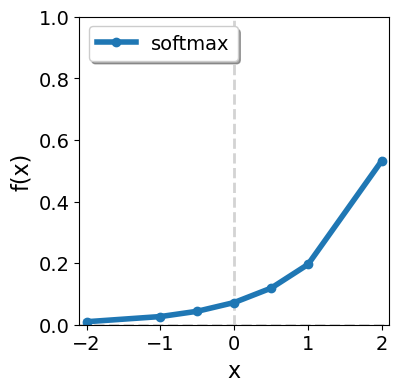

Sum of softmax values: 1.0


In [25]:
def softmax(x):
    e_x = np.exp(x - np.max(x)) #this implentation has a better numerical stability
    return e_x / e_x.sum()

z2 = [-2., -1., -0.5, 0., 0.5, 1., 2.]
figS, axS = plt.subplots(1, 1)
figS.set_size_inches(pw,ph)
axS.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axS.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axS.plot(z2, softmax(z2),linewidth=4,marker='o',label="softmax")
axS.legend(loc='upper left', shadow=True, fontsize='14')
axS.set_xlabel('x',fontdict={'fontsize':16})
axS.set_ylabel('f(x)',fontdict={'fontsize':16})
axS.set_xlim(-2.1, 2.1)
axS.set_ylim(0., 1.0)
axS.tick_params(labelsize = 14)
plt.show()
print(f"Sum of softmax values: {softmax(z2).sum()}")

In [26]:
vID.end(cwd0)

**End at:** Monday 31 October 2022, 20:56:06  
**Duration:** 00:12:26 454ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>